# Análise de Grafo Logístico
Este notebook realiza a leitura de dados de uma instância de grafo logístico, calcula estatísticas básicas e exibe uma visualização do grafo com distinção entre arestas obrigatórias e não obrigatórias.

---

## 1. Importação de Bibliotecas

Antes de tudo, importamos as bibliotecas necessárias e funções auxiliares responsáveis pela leitura dos dados, cálculo de estatísticas do grafo e cálculo das melhores rotas.

In [278]:
sys.path.append('./src')

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import math
import random
import time
import sys
import os
import analisys
from estatisticas_grafo import EstatisticasGrafo
from grafo import GrafoCARP


## 2. Leitura do Arquivo de Dados

Nesta etapa, realizamos a leitura do arquivo que contém os dados da instância do grafo logístico. Utilizamos a classe GrafoCARP para carregar e interpretar o arquivo, que contém as informações sobre os nós, arestas e arcos do grafo, separando as arestas obrigatórias das não obrigatórias.

In [279]:
nome_arquivo = input("Digite o nome do arquivo (por exemplo, BHW1.dat): ").strip()
caminho_arquivo = f"dados/{nome_arquivo}"

grafo_instancia = GrafoCARP(caminho_arquivo)  # cria o objeto GrafoCARP que já faz o parser
if not grafo_instancia or grafo_instancia.num_vertices == 0:
    print(f"⚠ Erro: dados inválidos no arquivo {caminho_arquivo}.")
else:
    print(f"✅ Grafo carregado com sucesso a partir de {caminho_arquivo}\n")

✅ Grafo carregado com sucesso a partir de dados/BHW5.dat



# 3. Cálculo das Estatísticas do Grafo

Com os dados do grafo carregados, utilizamos a classe EstatisticasGrafo para calcular informações relevantes sobre a estrutura do grafo, tais como: número de vértices, quantidade de arestas, grau mínimo e máximo dos nós, densidade, entre outras métricas importantes.

In [280]:
estatisticas = EstatisticasGrafo(grafo_instancia)
stats = estatisticas.calcular()

print(f"📊 Estatísticas do grafo ({caminho_arquivo}):")
for chave, valor in stats.items():
        # Formatando booleano para "Sim"/"Não"
    if isinstance(valor, bool):
        valor = "Sim" if valor else "Não"
    # Limitando floats a 4 casas decimais
    elif isinstance(valor, float):
        valor = f"{valor:.4f}"
    print(f"{chave}: {valor}")

📊 Estatísticas do grafo (dados/BHW5.dat):
1- Quantidade de vértices: 40
2- Quantidade de arestas: 0
3- Quantidade de arcos: 132
4- Quantidade de vértices obrigatórios: 30
5- Quantidade de arestas obrigatórias: 0
6- Quantidade de arcos obrigatórios: 132
7- É direcionado?: Sim
8- Densidade: 0.0846
9- Grau mínimo: 4
10- Grau máximo: 16
11- Intermedição: 3.3718
12- Caminho Médio: 14.1128
13- Diâmetro: 32


## 4. Posicionamento dos nós no espaço (visualização das interseções)

Aqui, cada ponto (ou nó) do grafo recebe uma posição no plano 2D para podermos visualizar o grafo como se fosse um mapa.

### Qual o objetivo?

Como os nós representam cruzamentos ou locais importantes, posicioná-los no plano ajuda a montar uma visão geral da rede de ruas. Isso facilita entender como as ruas estão conectadas e por onde os veículos podem circular.

### Como fizemos isso?

Geramos coordenadas aleatórias para cada nó dentro de uma área delimitada. Assim, conseguimos desenhar os pontos de forma distribuída, sem que fiquem colados nas bordas.

Mesmo sendo uma distribuição aleatória, ela já é suficiente para termos uma noção geral da estrutura do grafo e conseguirmos visualizar as conexões entre os nós depois.


In [281]:
largura, altura, margem = 10, 10, 1.5
posicoes = {no: (random.uniform(margem, largura - margem), random.uniform(margem, altura - margem))
    for no in range(1, grafo_instancia.num_vertices + 1)}

## 5. Visualização do grafo com cores específicas

Nesta parte, mostramos visualmente o grafo com as ruas e cruzamentos representados como conexões (arestas/arcos) e nós. A ideia é facilitar o entendimento das vias que precisam ou não ser percorridas no problema, além de deixar claro quando uma rua é mão única ou dupla.

### Como representamos as vias (ligações entre os nós):

- **Arestas obrigatórias (REE)**: São as ruas que devem ser atendidas e são de mão dupla. Aparecem como **linhas azuis sólidas**.
- **Arestas opcionais (EDGE)**: Ruas de mão dupla que podem ser usadas se forem vantajosas. Mostradas como **linhas ciano tracejadas**.
- **Arcos obrigatórios (REA)**: São vias obrigatórias de **mão única**. Aparecem como **setas verdes sólidas**.
- **Arcos opcionais (ARC)**: Vias de mão única que podem ser usadas ou não. Representadas por **setas roxas tracejadas**.

Cada via mostra também o seu **custo** (distância, tempo ou esforço para percorrer), indicado no meio da linha com um número.

### E os pontos (nós) do grafo:

- **Nós obrigatórios (REN)**: Representam locais que precisam ser visitados (como pontos de coleta). Aparecem como **círculos azul escuro** com o número branco no centro.
- **Nós opcionais**: São cruzamentos ou intersecções que podem ser usados apenas para passar. Aparecem como **círculos azul acinzentado**.

### Por que isso ajuda?

Essa visualização torna muito mais fácil:
- Ver quais ruas são mais importantes;
- Distinguir mão única de mão dupla;
- Entender como os custos estão distribuídos;
- Ter uma base clara para pensar em boas rotas.

Com isso, a estrutura do problema fica bem visível, e conseguimos partir para as próximas etapas com mais clareza.


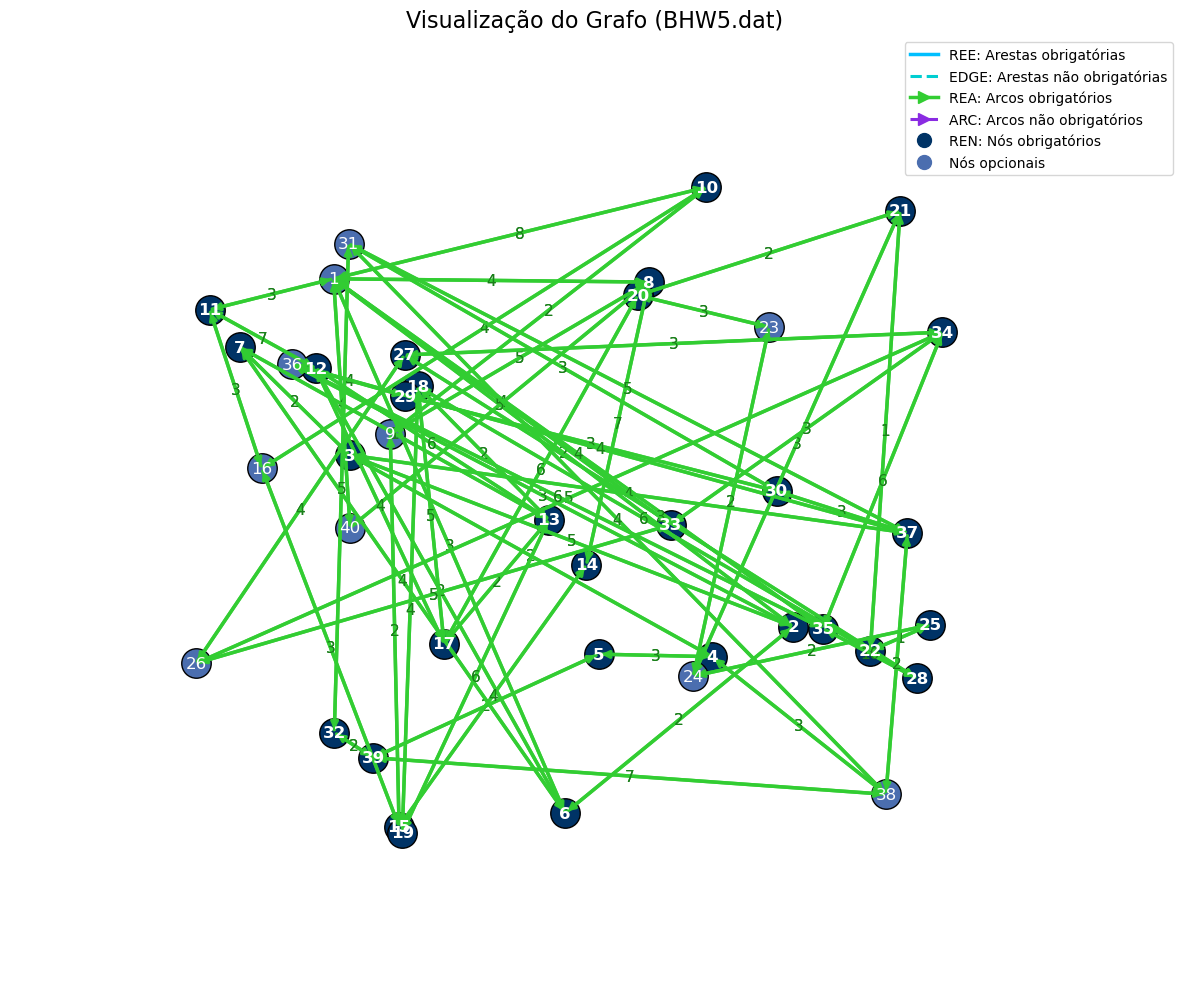

In [282]:
fig, ax = plt.subplots(figsize=(12, 10))

dados_grafo = grafo_instancia.get_dados()

# Arestas obrigatórias
for u, v, custo, *_ in dados_grafo['arestas_obrigatorias']:
    x1, y1 = posicoes[u]
    x2, y2 = posicoes[v]
    ax.plot([x1, x2], [y1, y2], color='#00BFFF', linewidth=2.5, alpha=0.95)
    ax.text((x1 + x2)/2, (y1 + y2)/2, f'{custo}', color='#005c87', fontsize=11, ha='center', va='center')

# Arestas não obrigatórias
for u, v, custo, *_ in dados_grafo['arestas_nao_obrigatorias']:
    x1, y1 = posicoes[u]
    x2, y2 = posicoes[v]
    ax.plot([x1, x2], [y1, y2], color='#00CED1', linestyle='--', linewidth=2.2, alpha=0.85)
    ax.text((x1 + x2)/2, (y1 + y2)/2, f'{custo}', color='#007374', fontsize=11, ha='center', va='center')

# Arcos obrigatórios
for u, v, custo, *_ in dados_grafo['arcos_obrigatorios']:
    x1, y1 = posicoes[u]
    x2, y2 = posicoes[v]
    ax.annotate("",
                xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", color='#32CD32', linewidth=2.5, alpha=0.95))
    ax.text((x1 + x2)/2, (y1 + y2)/2, f'{custo}', color='#1a7f1a', fontsize=11, ha='center', va='center')

# Arcos não obrigatórios
for u, v, custo, *_ in dados_grafo['arcos_nao_obrigatorios']:
    x1, y1 = posicoes[u]
    x2, y2 = posicoes[v]
    ax.annotate("",
                xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", linestyle='--', color='#8A2BE2', linewidth=2.2, alpha=0.9))
    ax.text((x1 + x2)/2, (y1 + y2)/2, f'{custo}', color='#4b0082', fontsize=11, ha='center', va='center')

# Nós obrigatórios
for no, info in dados_grafo['nos'].items():
    x, y = posicoes[no]
    ax.scatter(x, y, color='#003366', s=450, edgecolors='black')
    ax.text(x, y, str(no), fontsize=12, ha='center', va='center', color='white', weight='bold')

# Nós opcionais
vertices_todos = set(range(1, grafo_instancia.num_vertices + 1))
vertices_obrigatorios = set(dados_grafo['nos'].keys())
vertices_opcionais = vertices_todos - vertices_obrigatorios

for no in vertices_opcionais:
    x, y = posicoes[no]
    ax.scatter(x, y, color='#4B6EAF', s=450, edgecolors='black')
    ax.text(x, y, str(no), fontsize=12, ha='center', va='center', color='white')

ax.set_title(f"Visualização do Grafo ({nome_arquivo})", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, largura)
ax.set_ylim(0, altura)
ax.set_frame_on(False)

legenda = [
    Line2D([], [], color='#00BFFF', lw=2.5, label='REE: Arestas obrigatórias'),
    Line2D([], [], color='#00CED1', lw=2.2, linestyle='--', label='EDGE: Arestas não obrigatórias'),
    Line2D([], [], color='#32CD32', lw=2.5, label='REA: Arcos obrigatórios', marker='>', markersize=8),
    Line2D([], [], color='#8A2BE2', lw=2.2, linestyle='--', label='ARC: Arcos não obrigatórios', marker='>', markersize=8),
    Line2D([], [], marker='o', color='#003366', label='REN: Nós obrigatórios', markerfacecolor='#003366', markersize=10, linestyle='None'),
    Line2D([], [], marker='o', color='#4B6EAF', label='Nós opcionais', markerfacecolor='#4B6EAF', markersize=10, linestyle='None'),
]
ax.legend(handles=legenda, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Cálculo das melhores rotas e gravação do resultado

Nesta etapa, realizamos o cálculo das melhores rotas para cobrir todos os pontos obrigatórios do grafo logístico e salvamos o resultado em um arquivo `.dat`.

### Etapas realizadas:

- **Marcação dos tempos**: registramos o tempo total da execução e o tempo apenas do cálculo da solução para medir desempenho.
- **Cálculo das rotas**: utilizamos o método `path_scanning` para encontrar o melhor conjunto de rotas que cobre todos os pontos obrigatórios, considerando restrições de capacidade e minimizando o custo total.
- **Criação da pasta de saída**: garantimos que a pasta `solucoes` existe para armazenar o arquivo de resultado.
- **Gravação do resultado**: chamamos a função `salvar_resultado_arquivo`, que grava os detalhes do resultado e os tempos em um arquivo `.dat` para análise posterior.

In [283]:
inicio_total = time.monotonic_ns()

inicio_solucao = time.monotonic_ns()

resultado = analisys.path_scanning(grafo_instancia)

fim_solucao = time.monotonic_ns()
fim_total = time.monotonic_ns()

tempo_geral = fim_total - inicio_total
tempo_algoritmo = fim_solucao - inicio_solucao

pasta_saida = "solucoes"
os.makedirs(pasta_saida, exist_ok=True)  # cria a pasta se não existir

nome_saida = f"sol-{os.path.basename(caminho_arquivo).replace('.dat','')}.dat"
caminho_saida = os.path.join(pasta_saida, nome_saida)

analisys.salvar_resultado_arquivo(resultado, tempo_geral, tempo_algoritmo, caminho_saida)

print(f"✅ Resultado salvo em {caminho_saida}")

✅ Resultado salvo em solucoes/sol-BHW5.dat


## 7. Conclusão

Com este notebook, carregamos um grafo logístico com informações sobre ruas, distâncias e pontos obrigatórios a serem visitados. Fizemos o seguinte:

- Analisamos e calculamos estatísticas do grafo para entender melhor sua estrutura.
- Posicionamos os pontos no espaço para criar um “mapa” que ajuda a visualizar a rede.
- Diferenciamos as ruas obrigatórias das opcionais, assim como mão dupla e mão única.
- Encontramos automaticamente as melhores rotas que cobrem todos os pontos obrigatórios e gravamos o resultado.

Tudo isso ajuda a entender melhor a rede e facilita o planejamento de rotas mais eficientes e econômicas.
